In [23]:
import numpy as np
train_set = np.load('../data/HG002_2_3_00_400k_train.npz')
train_set.files

['features', 'labels', 'read_ids']

In [7]:
features = train_set['features']
features.shape

(256000, 6, 15)

In [8]:
features[0]

# ACGT, base quality, m6a score (dorado output normalized)
# left to right (7 before - central - 7 after)
# 7 or less

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ],
       [0.16078431, 0.17647059, 0.16078431, 0.16078431, 0.19607843,
        0.15686275, 0.15686275, 0.19607843, 0.19607843, 0.15686275,
        0.16470588, 0.19607843, 0.15294118, 

In [9]:
# compare base quality
print(np.min(features[:, 4, :]))
print(np.max(features[:, 4, :]))

0.00392156862745098
0.19607843137254902


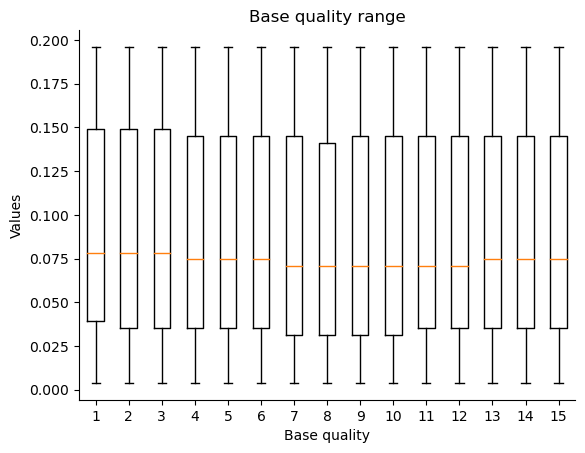

In [10]:
import matplotlib.pyplot as plt

data_to_plot = features[:, 4, :]

plt.boxplot(data_to_plot)

plt.xlabel('Base quality')
plt.ylabel('Values')
plt.title('Base quality range')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [11]:
above_threshold_mask = features[:, 4, :] > 0.05
all_above_threshold = np.all(above_threshold_mask, axis=1)
np.sum(all_above_threshold)

121907

In [12]:
2616972/5120000 * 100

51.112734375

In [13]:
labels = train_set['labels']
labels.shape

(256000,)

In [14]:
np.unique(labels, return_counts=True)
# balanced dataset

(array([0, 1], dtype=int64), array([128000, 128000], dtype=int64))

In [15]:
read_ids = train_set['read_ids']
read_ids.shape

(256000,)

In [16]:
print(len(np.unique(read_ids)))
np.unique(read_ids)

10589


array(['0010e35b-3962-44eb-84b5-f33166fd32ce',
       '001a12e3-3b0c-446a-9b5b-e5f0f6bb8a2b',
       '00267282-ee7f-4f39-b12e-3a281a4dd7ef', ...,
       'fff2267a-1ce5-4634-8323-4d181a2c754b',
       'fff4ab3e-a1db-44c3-9d33-b5052bfd5ca8',
       'ffffa7d9-dacb-42c5-a2c2-34045fdf594a'], dtype='<U36')

In [100]:
import numpy as np

# get bases loop form

def filter_set_by_base_quality(data, quality_threshold=0.05, drop_base_quality=True):
    features = data['features']
    labels = data['labels']
    import numpy as np

    list_above_threshold = []
    
    # Iterate through the data to check values
    for i in range(features.shape[0]):
        if features[i, 4, 7] > quality_threshold:
            list_above_threshold.append(i)
    
    above_threshold_indices = np.array(list_above_threshold)
    
    above_threshold_features = features[above_threshold_indices]
    above_threshold_labels = labels[above_threshold_indices]
    
    if drop_base_quality:
        above_threshold_features = above_threshold_features[:, np.arange(above_threshold_features.shape[1]) != 4, :]
    
    return above_threshold_features, above_threshold_labels

filtered_features, filtered_labels = filter_set_by_base_quality(train_set)


# vectorized version

# def filter_set_by_base_quality(data, quality_threshold=0.05, drop_base_quality=True):
#     features = data['features']
#     labels = data['labels']

#     above_threshold_mask = features[:, 4, :] > quality_threshold
#     all_above_threshold_features = features[:, above_threshold_mask, :]

#     all_above_threshold_indices = np.where(all_above_threshold_features)[0]


#     if drop_base_quality:
#         mask = np.arange(features.shape[1]) != 4
#         all_above_threshold_features = all_above_threshold_features[:, mask, :]

    
#     print(len(all_above_threshold_indices))
    
#     all_above_threshold_labels = labels[all_above_threshold_indices]

#     return all_above_threshold_features, all_above_threshold_labels


In [102]:
print(len(filtered_features) == len(filtered_labels))
print(filtered_features.shape)
len(filtered_features) / len(train_set['features']) * 100

True
(163831, 5, 15)


63.996484374999994

In [108]:
def set_num_nucleotides(features, num = 5):
    if num > 7:
        print('Cannot have more than 7 nucleotides.')
    else:
        num_to_remove = 7 - num
        
        keep_from_start = num_to_remove
        keep_from_end = features.shape[2] - num_to_remove

        new_features = features[:, :, keep_from_start:keep_from_end]
        
        return new_features

set_num_nucleotides(filtered_features, 5).shape

(163831, 5, 11)

In [ ]:
# basic lstm architecture
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out